# Neural Networks in NLP HW 2

## Дарья Родионова БКЛ182

Импортируем нужные модули.

In [1]:
import pandas as pd
import numpy as np
from string import punctuation
from collections import Counter
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import f1
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from gensim.models import FastText
import ipdb
import spacy
import tqdm

Скачиваем твиты.

In [2]:
pos_tweets = pd.read_csv('positive.csv', encoding='utf-8', sep=';', header=None,  names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
neg_tweets = pd.read_csv('negative.csv', encoding='utf-8', sep=';', header=None, names=[0,1,2,'text','tone',5,6,7,8,9,10,11])
all_tweets_data = pos_tweets.append(neg_tweets)

In [3]:
all_tweets_data = pos_tweets.append(neg_tweets)
all_tweets_data.tone.replace({-1: 0}, inplace=True)
all_tweets_data = shuffle(all_tweets_data[['text','tone']])[:100000]

### Preprocessing

Почистим данные перед обучением модели. 

In [4]:
def preprocess(text): 
    text = text.lower().replace("ё", "е")
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', text)
    text = re.sub('@[^\s]+', 'USER', text)
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +', ' ', text)
    return text.split()

In [5]:
all_tweets_data['clean_data'] = all_tweets_data.text.apply(lambda x: ' '.join(preprocess(x)))

In [6]:
train_sentences, val_sentences = train_test_split(all_tweets_data, test_size=0.2)

In [7]:
train_sentences[train_sentences.tone == 1].shape[0]/train_sentences.shape[0]

0.5064875

In [8]:
train_sentences[:10]

,text,tone,clean_data
64505,@nik_korot http://t.co/DwZeFNvvqi А на этой фо...,1,USER URL а на этой фотографии кого нибудь узнаешь
90737,Вот и Питерский наш уезжает ((( http://t.co/vK...,0,вот и питерский наш уезжает URL
58809,Горсть домашки это злооо\nсобенно перед праздн...,0,горсть домашки это злооо собенно перед праздни...
108332,"@Crazy_snail_ ВААТ?? Тот чувак, который с голы...",1,USER ваат тот чувак который с голым торсом это...
47045,RT @xegakyrysyv: Я закрыла дверь в свое сердце...,1,rt USER я закрыла дверь в свое сердце и написа...
24176,Грустно... :( по крайней мере три дня мне еще ...,0,грустно по крайней мере три дня мне еще будет ...
1215,RT @jopixilafyle: я уже замучался аплоадить 1....,0,rt USER я уже замучался аплоадить 1 5гб контен...
54671,"""Эээ? Это что получается, что я не настоящий?)...",1,эээ это что получается что я не настоящий прий...
58369,RT @Podslyshano: Чтобы залечить свои душевные ...,0,rt USER чтобы залечить свои душевные раны ищу ...
23337,@MigalAnn :С както печально:( а что рисовать л...,0,USER с както печально а что рисовать любишь


### CNN

### Dataloader

In [9]:
vocab = Counter()

for text in all_tweets_data['clean_data']:
    vocab.update(text.split())
print('Всего уникальных токенов:', len(vocab))

Всего уникальных токенов: 111273


In [10]:
vocab.most_common(10)

[('USER', 65538),
 ('не', 33243),
 ('я', 29065),
 ('и', 26840),
 ('в', 25677),
 ('на', 16807),
 ('rt', 16675),
 ('что', 16075),
 ('а', 15883),
 ('URL', 14588)]

In [11]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 1:
        filtered_vocab.add(word)
print('Уникальных символов, втретившихся больше 1 раза:', len(filtered_vocab))

Уникальных символов, втретившихся больше 1 раза: 44646


Создаем предобученные эмбеддинги.

In [12]:
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [13]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cpu')

### Dataset

In [14]:
class TweetsDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [15]:
train_dataset = TweetsDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [16]:
val_dataset = TweetsDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [17]:
from gensim.models import FastText

model = FastText(all_tweets_data['clean_data'].tolist(), size=100, window=5, min_count=1)

In [18]:
weights = np.zeros((len(word2id), 100))
count = 0
for word, i in word2id.items():
    if word == 'PAD':
        continue   
    try:
        weights[i] = model.wv[word]    
    except KeyError:
      count += 1
      weights[i] = np.random.normal(0,0.1,100)

In [19]:
class CNN(nn.Module):

    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_cat = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.relu(self.bigrams(embedded))
        feature_map_trigrams = self.relu(self.trigrams(embedded))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.pooling(self.relu(self.bigrams_over_cat(concat)))
        pooling = bigrams.max(2)[0] 

        logits = self.hidden(pooling) 
        logits = self.out(logits)      
        return logits

In [20]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    
    model.train()

    for i, (texts, ys) in enumerate(iterator):
        optimizer.zero_grad()
        preds = model(texts)
        loss = criterion(preds, ys)  

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [21]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 

    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)

            loss = criterion(preds, ys)
            
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val metric: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [22]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [23]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Train loss: 0.7449675670691899
Train loss: 0.7173425534675861
Train loss: 0.7087747088887475
Train loss: 0.7041335994914427
Train loss: 0.701034744043608

Evaluating on train...
Val loss: 0.7367093009608132, Val metric: 0.563019871711731
Val loss: 0.710804898163368, Val metric: 0.544930636882782
Val loss: 0.7024604434316809, Val metric: 0.5423845648765564
Val loss: 0.6985302759429156, Val metric: 0.5385636687278748
Val loss: 0.6961986366155986, Val metric: 0.5369848608970642

Evaluating on test...
Val loss: 0.9189053177833557, Val metric: 0.6926988959312439
Val loss: 0.7854937144688198, Val metric: 0.6083716154098511
Val loss: 0.7507128444584933, Val metric: 0.5732309818267822
Val loss: 0.7341633955637614, Val metric: 0.5561426877975464
Val loss: 0.7248410519800688, Val metric: 0.5473593473434448

Epoch 1
Training...
Train loss: 0.7376892226082938
Train loss: 0.7106049328014769
Train loss: 0.7020224752751264
Train loss: 0.6977647906642849
Train loss: 0.6952273797344517

Evaluating on t

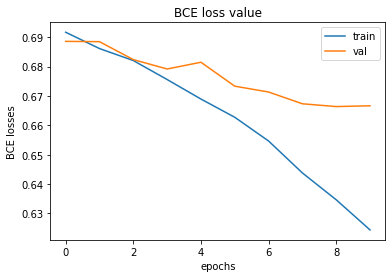

In [24]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('BCE loss value')
plt.ylabel('BCE losses')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

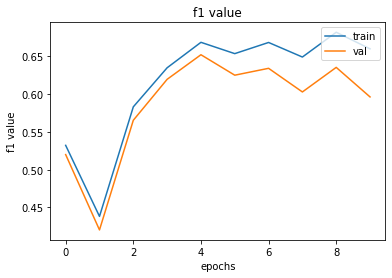

In [25]:
plt.plot(f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [26]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (texts, ys) in enumerate(iterator):   
            preds = model(texts)
            for pred, gold, text in zip(preds, ys, texts):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [27]:
fp, fn, tp, tn = predict(model, val_iterator)

In [28]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.5963552154651631

Результат вполне сомнительный. 

### Updated CNN

Попробуем улучшить модель, добавив droput и weight decay. Также изменим embedding_dim на 5. 

In [34]:
class UpdatedCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.bigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.trigrams = nn.Conv1d(in_channels=embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.bigrams_over_cat = nn.Conv1d(in_channels=180, out_channels=180, kernel_size=2, padding='same')
        self.pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.hidden = nn.Linear(in_features=180, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, word):
        embedded = self.embedding(word)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.relu(self.bigrams(embedded)))
        feature_map_trigrams = self.dropout(self.relu(self.trigrams(embedded)))

        concat = torch.cat((feature_map_bigrams, feature_map_trigrams), 1)
        bigrams = self.dropout(self.pooling(self.relu(self.bigrams_over_cat(concat))))
        pooling = bigrams.max(2)[0] 

        logits = self.dropout(self.hidden(pooling))
        logits = self.out(logits)      
        return logits

In [35]:
model = UpdatedCNN(len(word2id), 5)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [36]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.8758234339100974
Train loss: 0.7944967130134846
Train loss: 0.7633373818614266
Train loss: 0.747141620870364
Train loss: 0.7377789785733094

Evaluating on train...
Val loss: 0.740132966211864, Val metric: 0.278911292552948
Val loss: 0.7141625346808598, Val metric: 0.2608906924724579
Val loss: 0.7058753913099115, Val metric: 0.25882357358932495
Val loss: 0.7022123892428511, Val metric: 0.25579386949539185
Val loss: 0.6998308027112806, Val metric: 0.25634342432022095

Evaluating on test...
Val loss: 0.9243595600128174, Val metric: 0.3201352059841156
Val loss: 0.7910914421081543, Val metric: 0.2888168692588806
Val loss: 0.7544517842206088, Val metric: 0.27383747696876526
Val loss: 0.7377933263778687, Val metric: 0.2597495913505554
Val loss: 0.7277418814207378, Val metric: 0.2566530704498291

Epoch 1
Training...
Train loss: 0.7506511637142727
Train loss: 0.7235738861149755
Train loss: 0.7148156450553373
Train loss: 0.7104386313486908
Train loss: 0.7075047

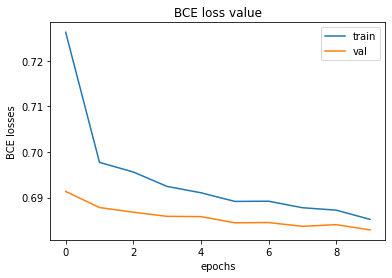

In [37]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('BCE loss value')
plt.ylabel('BCE losses')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

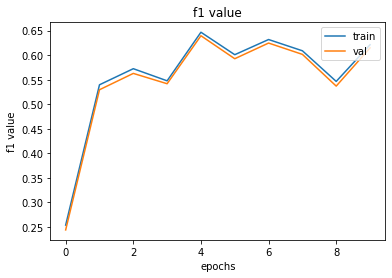

In [38]:
plt.plot(f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [39]:
fp, fn, tp, tn = predict(model, val_iterator)

In [40]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.6149810023520897

Стало чуть-чуть получше, но не намного. Посмотрим на примеры, в которых ошибается модель.

In [30]:
fp[:5]

['и слава кому что',
 'сошел с перетасовал всех так сразу нужных людей и не',
 'не стоит ли возвращать что было',
 'теперь можешь посмеяться с моих',
 'комиссионную контрольную по алгебре на 3 уверена что точно не']

In [29]:
fn[:5]

['за месяц стали как',
 'же больше всего разочаровывают слабые стороны от чего ожидаешь завтрашняя часть перекроет',
 'меня заместь на я сказала что люблю а она сказала что я так и говори людям что ты их',
 'же соберу все свое мужество в кулак и надо она ниче не',
 'завтра же в кино в я']

Сложно что-то сказать про закономерность на ошибочно классифицированных примерах. Мне кажется, что в целом ошибки модели объяснимы: в отрыве от контекста даже человеку иногда очень сложно определить тональность высказывания. 

### 2. Модель без предобработки данных

До этого мы не смотрели на смайлики и знаки препинания. Попробуем обучить модель вместе с ними.

In [41]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()

### Dataloader

In [42]:
vocab = Counter()
for text in all_tweets_data['text']:
    vocab.update(text.split(' '))
for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

In [43]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
    
id2word = {i:word for word, i in word2id.items()}

### Dataset

In [44]:
class RawDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = tt.tokenize(self.dataset[index])
        ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_ids, y

In [45]:
model = CNN(len(word2id), 2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [46]:
train_dataset = RawDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [47]:
val_dataset = RawDataset(val_sentences, word2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [48]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.688578976052148
Train loss: 0.6174518465995789
Train loss: 0.5696805234659802
Train loss: 0.5260542848352658
Train loss: 0.48653403327271744

Evaluating on train...
Val loss: 0.30975367554596495, Val metric: 0.9500924944877625
Val loss: 0.295629457153123, Val metric: 0.9202280640602112
Val loss: 0.2929521744901484, Val metric: 0.909008800983429
Val loss: 0.29067744390439176, Val metric: 0.904324471950531
Val loss: 0.2906046417113897, Val metric: 0.9004938006401062

Evaluating on test...
Val loss: 0.37051772077878314, Val metric: 1.193864107131958
Val loss: 0.32072716525622774, Val metric: 1.0203136205673218
Val loss: 0.30953866785222833, Val metric: 0.9711889624595642
Val loss: 0.3035271386305491, Val metric: 0.9496087431907654
Val loss: 0.3000969071137278, Val metric: 0.9359857439994812

Epoch 1
Training...
Train loss: 0.29465989555631367
Train loss: 0.270212986859782
Train loss: 0.25488751381635666
Train loss: 0.24446855409670684
Train loss: 0.23519

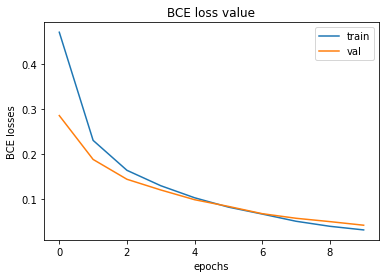

In [49]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('BCE loss value')
plt.ylabel('BCE losses')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

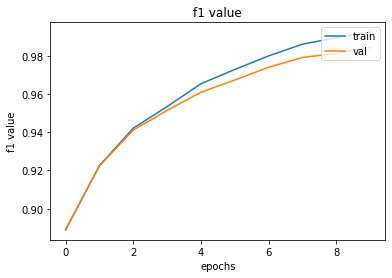

In [50]:
plt.plot(f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [51]:
fp, fn, tp, tn = predict(model, val_iterator)

In [52]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.9839945011783189

Наличие смайликов и знаков препинания сильно повлияло на качество модели. В целом, это ожидаемо, так как твиты и другие комментарии в соцсетях очень часто экспрессивны, поэтому содержат смайлики и другие знаки (например, скобочки) для выражения эмоций. 

### 2. Модель с двумя входами

### Dataloader

In [55]:
vocab = Counter()

for text in all_tweets_data['clean_data']:
    vocab.update(text.split())
  
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 1:
        filtered_vocab.add(word)

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [56]:
char_vocab = Counter()

for text in all_tweets_data['clean_data']:
    for word in text:
      char_vocab.update(list(word))

filtered_char_vocab = set()

for word in char_vocab:
    if char_vocab[word] > 10:
        filtered_char_vocab.add(word)

symbol2id = {'PAD':0}

for symbol in filtered_char_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

### Dataset

Сразу добавим dropout, чтобы избежать переобучения. 

In [57]:
class WordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['clean_data'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = self.dataset[index].split()
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch):
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [58]:
train_dataset = WordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

In [59]:
val_dataset = WordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [74]:
class WordSymbCNN(nn.Module):

    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # word-level layers
        self.word_embedding = nn.Embedding(word_vocab_size, 100)
        self.word_embedding.from_pretrained(torch.tensor(weights), freeze=True)
        self.word_hidden = nn.Linear(100, 100) 

        # symbol-level layers
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=80, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=180, out_features=100)
        
        # universal layers
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()   
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        embedded = self.symb_embedding(symb_seq)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))

        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)  
        mean_emb_words = torch.mean(embedded_words, dim=1)
        word_vec = self.dropout(self.word_hidden(mean_emb_words))
        word_vec = self.dropout(self.relu(word_vec))

        concat = torch.cat((symb_vec, word_vec), 1)
        logits = self.out(self.linear(concat))      
        return logits

In [61]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0

    model.train()

    for i, (word_seq, symb_seq, ys) in enumerate(iterator): 
        optimizer.zero_grad()
        preds = model(word_seq, symb_seq)
        loss = criterion(preds, ys) 
        loss.backward() 
        optimizer.step()
        epoch_loss += loss.item()
        if not (i + 1) % int(len(iterator)/5):
            print(f'Train loss: {epoch_loss/i}')      
    return  epoch_loss / len(iterator)

In [62]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_metric = 0
    model.eval() 
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):   
            preds = model(word_seq, symb_seq)
            loss = criterion(preds, ys)
            epoch_loss += loss.item()
            batch_metric = f1(preds.round().long(), ys.long(), ignore_index=0)
            epoch_metric += batch_metric

            if not (i + 1) % int(len(iterator)/5):
              print(f'Val loss: {epoch_loss/i}, Val metric: {epoch_metric/i}')
        
    return epoch_metric / len(iterator), epoch_loss / len(iterator)

In [63]:
model = WordSymbCNN(len(symbol2id), 8, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [64]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.8258845678397587
Train loss: 0.7602222459069614
Train loss: 0.7344000339508057
Train loss: 0.718605334475889
Train loss: 0.7073647637624998

Evaluating on train...
Val loss: 0.7159669739859444, Val metric: 0.6662214398384094
Val loss: 0.6905391894537827, Val metric: 0.6499683260917664
Val loss: 0.682429472153837, Val metric: 0.6471801400184631
Val loss: 0.678449982303684, Val metric: 0.6441304087638855
Val loss: 0.6761804110295063, Val metric: 0.6425334215164185

Evaluating on test...
Val loss: 0.8924075365066528, Val metric: 0.8406431674957275
Val loss: 0.7640071085521153, Val metric: 0.7238415479660034
Val loss: 0.7281820340590044, Val metric: 0.6980190873146057
Val loss: 0.7121260603268941, Val metric: 0.6820590496063232
Val loss: 0.7027906869587145, Val metric: 0.6724215745925903

Epoch 1
Training...
Train loss: 0.7014424204826355
Train loss: 0.6722899202642769
Train loss: 0.6600977128202264
Train loss: 0.652079477148541
Train loss: 0.645408348457

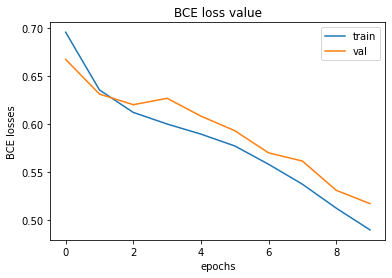

In [65]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('BCE loss value')
plt.ylabel('BCE losses')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

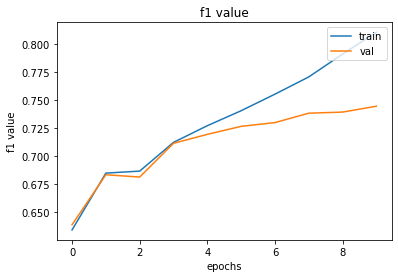

In [66]:
plt.plot(f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [68]:
def predict(model, iterator):
    model.eval()
    fp = []
    fn = []
    tp = [] 
    tn = []
    with torch.no_grad():
        for i, (word_seq, symb_seq, ys) in enumerate(iterator):  
            preds = model(word_seq, symb_seq)  
            for pred, gold, text in zip(preds, ys, word_seq):
              text = ' '.join([id2word[int(word)] for word in text if word !=0])
              if round(pred.item()) > gold:
                fp.append(text)
              elif round(pred.item()) < gold:
                fn.append(text)
              elif round(pred.item()) == gold == 1:
                tp.append(text)
              elif round(pred.item()) == gold == 0:
                tn.append(text)
    return fp, fn, tp, tn

In [69]:
fp, fn, tp, tn = predict(model, val_iterator)

In [70]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7441227899747426

В целом получился неплохой результат. Добавим побольше линейных слоев и параметров и поменяем активацию. 

In [75]:
class UpdatedWordSymbCNN(nn.Module):

    def __init__(self, symb_vocab_size, symb_embedding_dim, word_vocab_size):
        super().__init__()

        # word-level layers
        self.word_embedding = nn.Embedding(word_vocab_size, 300)
        self.word_hidden = nn.Linear(300, 100) 

        # symbol-level layers
        self.symb_embedding = nn.Embedding(symb_vocab_size, symb_embedding_dim)
        self.symb_bigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=200, kernel_size=2, padding='same')
        self.symb_trigrams = nn.Conv1d(in_channels=symb_embedding_dim, out_channels=100, kernel_size=3, padding='same')
        self.symb_pooling = nn.MaxPool1d(kernel_size=2, stride=2)
        self.symb_hidden = nn.Linear(in_features=300, out_features=100)

        # universal layers
        self.linear0 = nn.Linear(in_features=200, out_features=200)
        self.linear = nn.Linear(in_features=200, out_features=1)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.LeakyReLU()   
        self.out = nn.Sigmoid()

    def forward(self, words_seq, symb_seq):
        embedded = self.symb_embedding(symb_seq)
        embedded = embedded.transpose(1,2)
        feature_map_bigrams = self.dropout(self.symb_pooling(self.relu(self.symb_bigrams(embedded))))
        feature_map_trigrams = self.dropout(self.symb_pooling(self.relu(self.symb_trigrams(embedded))))

        pooling1 = feature_map_bigrams.max(2)[0] 
        pooling2 = feature_map_trigrams.max(2)[0]
        concat = torch.cat((pooling1, pooling2), 1)
        symb_vec = self.symb_hidden(concat)

        embedded_words = self.word_embedding(words_seq)
        mean_emb_words = torch.mean(embedded_words, dim=1)
        word_vec = self.dropout(self.word_hidden(mean_emb_words))
        word_vec = self.dropout(self.relu(word_vec))

        concat = torch.cat((symb_vec, word_vec), 1)

        hidden = self.dropout(self.out(self.linear0(concat)))
        logits = self.out(self.linear(hidden))      
        return logits

In [84]:
model = UpdatedWordSymbCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [85]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.7544289401599339
Train loss: 0.7228895261369902
Train loss: 0.709385247393088
Train loss: 0.6992298132282192
Train loss: 0.6890477779749278

Evaluating on train...
Val loss: 0.670964104788644, Val metric: 0.7327276468276978
Val loss: 0.6486169428660952, Val metric: 0.7059345841407776
Val loss: 0.6417192383245989, Val metric: 0.698243260383606
Val loss: 0.6387911327814652, Val metric: 0.6935480237007141
Val loss: 0.6370585802439097, Val metric: 0.6905213594436646

Evaluating on test...
Val loss: 0.8425081372261047, Val metric: 0.9108982682228088
Val loss: 0.7227627975600106, Val metric: 0.7779647707939148
Val loss: 0.6876950372349132, Val metric: 0.7439260482788086
Val loss: 0.6733619213104248, Val metric: 0.7254002690315247
Val loss: 0.664290537959651, Val metric: 0.715398907661438

Epoch 1
Training...
Train loss: 0.6668042327676501
Train loss: 0.6355731918894011
Train loss: 0.6247491958466443
Train loss: 0.6171109949128103
Train loss: 0.6102961978396

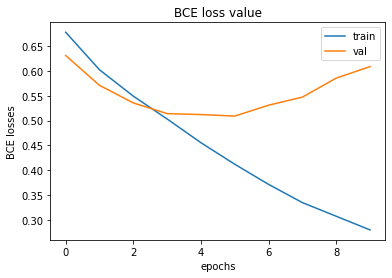

In [86]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('BCE loss value')
plt.ylabel('BCE losses')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

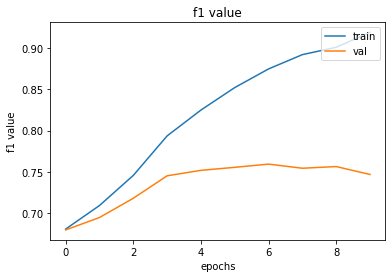

In [87]:
plt.plot(f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [88]:
fp, fn, tp, tn = predict(model, val_iterator)

In [89]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.7466813055195131

Ну... качество улучшилось, конечно, но совсем чуть-чуть. С примерами всё так же непонятно и сложно, но можно заметить, что модель не понимает сарказма (слава богу, хохо). 

In [90]:
fp[:5]

['USER USER и слава богу хоть знаем кому что принадлежит',
 'не знаю стоит ли возвращать то что было тогда',
 'USER теперь можешь посмеяться с моих пальцев сарделек',
 'написала комиссионную контрольную по алгебре на 3 теперь уверена что гиа точно не здам',
 'rt USER USER хохо а я ведь собирался спать 3 кароч вышло говно URL']

In [91]:
fn[:5]

['линта я пошел спать всем макоронных снов с теплым одеялком с',
 'USER я его всегда любила мастер по обсыранию людей которые идут по улице',
 'в принципе определились где будем отмечать новый год',
 'аня поведет меня заместь кино на каток я сказала что люблю ее а она сказала что я пьяная мда вот так и говори людям что ты их любишь',
 'ни когда не понимал целые они или с уже с дефектом история URL']

### Модель без предобработки данных

Теперь прогоним ту же сетку на непредобработанных данных. 

### Dataloader

In [98]:
vocab = Counter()

for text in all_tweets_data['text']:
    vocab.update(text.split())

word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [99]:
char_vocab = Counter()

for text in all_tweets_data['text']:
    for word in text:
      char_vocab.update(list(word))

symbol2id = {'PAD':0}

for symbol in filtered_char_vocab:
    symbol2id[symbol] = len(symbol2id)

id2symbol = {i:symbol for symbol, i in symbol2id.items()}

### Dataset

In [100]:
class RawWordSymbDataset(Dataset):

    def __init__(self, dataset, word2id, symbol2id, DEVICE):
        self.dataset = dataset['text'].values
        self.word2id = word2id
        self.symbol2id = symbol2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['tone'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        symbols = list(self.dataset[index])
        symb_ids = torch.LongTensor([self.symbol2id[symbol] for symbol in symbols if symbol in self.symbol2id])
        tokens = tt.tokenize(self.dataset[index])
        word_ids = torch.LongTensor([self.word2id[token] for token in tokens if token in self.word2id])
        y = [self.target[index]]
        return word_ids, symb_ids, y

    def collate_fn(self, batch):
      word_ids, symb_ids, y = list(zip(*batch))
      padded_words = pad_sequence(word_ids, batch_first=True).to(self.device)
      padded_symbs = pad_sequence(symb_ids, batch_first=True).to(self.device)
      y = torch.Tensor(y).to(self.device)
      return padded_words, padded_symbs, y

In [106]:
train_dataset = RawWordSymbDataset(train_sentences, word2id, symbol2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=1024)

val_dataset = RawWordSymbDataset(val_sentences, word2id, symbol2id, DEVICE)
val_sampler = SequentialSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=1024)

In [107]:
model = WordSymbCNN(len(symbol2id), 10, len(word2id))
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

model = model.to(DEVICE)
criterion = criterion.to(DEVICE)

In [108]:
losses = []
val_losses = []
f1s = []
val_f1s = []

for i in range(10):
    print(f'\nEpoch {i}')
    print('Training...')
    epoch_loss = train(model, train_iterator, optimizer, criterion)
    losses.append(epoch_loss)
    print('\nEvaluating on train...')
    f1_on_train,_ = evaluate(model, train_iterator, criterion)
    f1s.append(f1_on_train)
    print('\nEvaluating on test...')
    f1_on_test, epoch_loss_on_test = evaluate(model, val_iterator, criterion)
    val_losses.append(epoch_loss_on_test)
    val_f1s.append(f1_on_test)


Epoch 0
Training...
Train loss: 0.7802584554467883
Train loss: 0.7260755876014973
Train loss: 0.6983560554005883
Train loss: 0.6764584971686541
Train loss: 0.6545013422901566

Evaluating on train...
Val loss: 0.5579221291201455, Val metric: 0.8666805624961853
Val loss: 0.536476653197716, Val metric: 0.8393943309783936
Val loss: 0.5293999720703472, Val metric: 0.8309888243675232
Val loss: 0.5266305743637731, Val metric: 0.8257179260253906
Val loss: 0.5255904640700366, Val metric: 0.821155846118927

Evaluating on test...
Val loss: 0.6869226495424906, Val metric: 1.1002572774887085
Val loss: 0.5942298599651882, Val metric: 0.9241905212402344
Val loss: 0.567570838061246, Val metric: 0.8842573165893555
Val loss: 0.5545675237973531, Val metric: 0.8635742664337158
Val loss: 0.5479340616025423, Val metric: 0.8518394827842712

Epoch 1
Training...
Train loss: 0.5289054619414466
Train loss: 0.48655552596881474
Train loss: 0.4528133828531612
Train loss: 0.42400263780254427
Train loss: 0.397864234

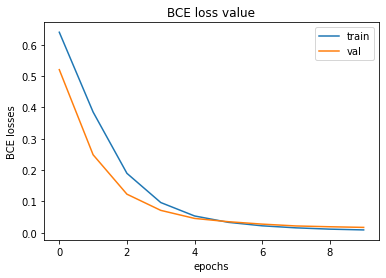

In [109]:
plt.plot(losses)
plt.plot(val_losses)
plt.title('BCE loss value')
plt.ylabel('BCE losses')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

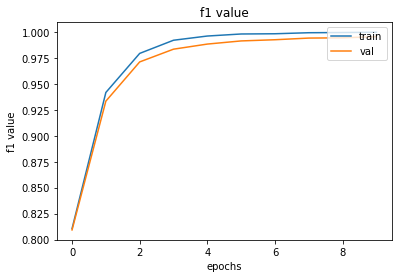

In [110]:
plt.plot(f1s)
plt.plot(val_f1s)
plt.title('f1 value')
plt.ylabel('f1 value')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [111]:
fp, fn, tp, tn = predict(model, val_iterator)

Ещё раз посмотрим 

In [112]:
recall = len(tp)/(len(tp) + len(fn))
precision = len(tp)/(len(tp) + len(fp))
f_score = 2 * precision * recall / (precision + recall)
f_score

0.9955072821525549

Качестов значительно улучшилось, и вывод, собственно, следующий: смайлики и скобочки очень сильно влияют на оценку тональности. С данным датасетом нам повезло, но вообще, как уже было сказано, даже со знаками препинания и смайликами не всегда можно понять окраску высказываний. 